In [1]:
# Import required packages
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
%%time
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

CPU times: user 5.48 s, sys: 3.79 s, total: 9.27 s
Wall time: 12.6 s


For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer
CPU times: user 168 ms, sys: 5.22 ms, total: 173 ms
Wall time: 176 ms


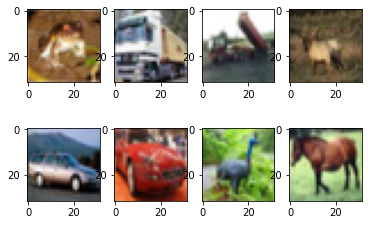

In [3]:
%%time
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    # The class-label correspondence
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    label_num = int(clf.predict(feature)[0])
 
    return classes[label_num]

### 2.2. Model I

In [7]:
import utils
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from random import shuffle
import time

In [8]:
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
net = utils.Net()

In [9]:
dataset = utils.Image_dataset("../data/images/","../output/data_csv.csv",transform=transform)
train_set, validation_set = torch.utils.data.random_split(dataset,[25000,25000])
train_loader = DataLoader(train_set, batch_size=4,)
validation_loader = DataLoader(validation_set, batch_size=4)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
%%time
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.303
[1,  4000] loss: 2.303
[1,  6000] loss: 2.304
[2,  2000] loss: 2.303
[2,  4000] loss: 2.303
[2,  6000] loss: 2.303
Finished Training
CPU times: user 1min 11s, sys: 4.67 s, total: 1min 16s
Wall time: 1min 15s


In [12]:
PATH = '../output/model.pth'
torch.save(net.state_dict(), PATH)

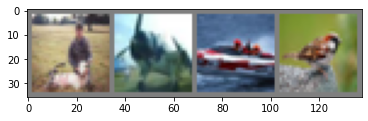

GroundTruth:  truck ship  cat   dog  


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(validation_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[int(labels[j])]:5s}' for j in range(4)))

In [14]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  car   car   cat   cat  


In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [16]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    label_num = int(forest_clf.predict(feature)[0])
    
    return classes[label_num]

### 2.2 Model I -Rhea

In [17]:
# Splitting data into training and test sets 

x_train, x_test,y_train, y_test = train_test_split(imgs, noisy_labels, test_size = 0.2, random_state=42)

x_train = tf.cast(x_train, dtype='float32')/255.0
x_test = tf.cast(x_test, dtype='float32')/255.0

y_train = tf.one_hot(y_train, depth=10)

In [19]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]
start_time = time.time()

# CNN
model_one_cnn = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,(3,3),padding='same', activation ='relu', input_shape=(32,32,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Conv2D(64,(3,3),padding='same', activation ='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Dense(10, activation = 'softmax')        
                                ])
        
model_one_cnn.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = ['accuracy'])
    
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
        
        
history = model_one_cnn.fit(x_train, y_train, batch_size= 64,epochs=15,
          validation_split= 0.2, callbacks=[early_stop, time_callback])


Epoch 1/15
500/500 [==============================] - 47s 92ms/step - loss: 2.3006 - accuracy: 0.1103 - val_loss: 2.2863 - val_accuracy: 0.1341
Epoch 2/15
500/500 [==============================] - 47s 93ms/step - loss: 2.2793 - accuracy: 0.1403 - val_loss: 2.2678 - val_accuracy: 0.1690
Epoch 3/15
500/500 [==============================] - 46s 92ms/step - loss: 2.2665 - accuracy: 0.1552 - val_loss: 2.2624 - val_accuracy: 0.1762
Epoch 4/15
500/500 [==============================] - 49s 97ms/step - loss: 2.2592 - accuracy: 0.1628 - val_loss: 2.2501 - val_accuracy: 0.1908
Epoch 5/15
500/500 [==============================] - 46s 92ms/step - loss: 2.2495 - accuracy: 0.1730 - val_loss: 2.2502 - val_accuracy: 0.1910
Epoch 6/15
500/500 [==============================] - 46s 92ms/step - loss: 2.2429 - accuracy: 0.1800 - val_loss: 2.2400 - val_accuracy: 0.2004
Epoch 7/15
500/500 [==============================] - 49s 98ms/step - loss: 2.2377 - accuracy: 0.1861 - val_loss: 2.2361 - val_accuracy:

In [20]:
print(f'Model 1 (CNN) took about {sum(time_callback.times)/60} minutes to train.')

Model 1 (CNN) took about 12.015274898211162 minutes to train.


### 2.3. Model II

In [21]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [22]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [23]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

OSError: ../data/test_labels.csv not found.

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.